# Country Statistics
This script will calculate the country insights into the accepted papers based on the data from `./data-proceedings/authors.csv`.

Author: Sven Mayer (info@sven-mayer.com)

LICENSE: GPL-3.0 license 

In [1]:
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import scipy.stats

colors = ["#FF523F","#FFAD33","#198D6D","#6599FF","#683b96","#f07adb"]

import geopandas
gdf = geopandas.read_file("./utils/ne_10m_admin_0_countries_lakes.shp")[['ADMIN', 'ADM0_A3', "geometry"]]
gdf = gdf.rename(columns = {"ADMIN":"Country", "ADM0_A3":"Alpha-3"})
dfISO3166 = pd.read_csv("./utils/ISO-3166-Countries-with-Regional-Codes.csv")
del gdf["Country"]
gdf= pd.merge(gdf, dfISO3166, on="Alpha-3", how="left")
gdf = gdf[~gdf.Country.isna()]
gdf = gdf[["Country", "Alpha-3", "Region", "Sub-Region", "geometry"]]

In [2]:
df = pd.read_csv("./data-proceedings/authors.csv")

dfCount = df.Url.value_counts()
dfCount = dfCount.reset_index()
dfCount = dfCount.rename(columns={'count': 'AuthorContributionCount'})

if ("AuthorContributionCount" in df.columns):
    df = df.drop(columns=["AuthorContributionCount"])

df = pd.merge(df, dfCount, left_on='Url', right_on='Url', how='left')


dfCount = df.Doi.value_counts()
dfCount = dfCount.reset_index()
dfCount = dfCount.rename(columns={'count': 'AuthorPaperCount'})

if ("AuthorPaperCount" in df.columns):
    df = df.drop(columns=["AuthorPaperCount"])

df = pd.merge(df, dfCount, left_on='Doi', right_on='Doi', how='left')

df["AuthorContribution"] = 1/df.AuthorPaperCount


print(len(df))
df.head()


3714


,Year,Doi,Title,Order,Name,Affiliation,Alpha-3,Url,Type,Session,AuthorContributionCount,AuthorPaperCount,AuthorContribution
0,2005,10.1145/1085777.1085779,NaN,1,Dan Hong,Hong Kong University of Science and Technology,HKG,https://dl.acm.org/profile/81100648888,ARTICLE,SESSION: Social communication,1.0,3,0.333333
1,2005,10.1145/1085777.1085779,NaN,2,Mingxuan Yuan,Xi'an Jiaotong University,CHN,https://dl.acm.org/profile/81542861056,ARTICLE,SESSION: Social communication,1.0,3,0.333333
2,2005,10.1145/1085777.1085779,NaN,3,Vincent Yun Shen Shen,Hong Kong University of Science and Technology,HKG,https://dl.acm.org/profile/81100343034,ARTICLE,SESSION: Social communication,1.0,3,0.333333
3,2005,10.1145/1085777.1085780,NaN,1,Stavros Antifakos,ETH Zurich,CHE,https://dl.acm.org/profile/81100278693,ARTICLE,SESSION: Social communication,1.0,4,0.250000
4,2005,10.1145/1085777.1085780,NaN,2,Nicky Kern,Technical University of Darmstadt,DEU,https://dl.acm.org/profile/81100599042,ARTICLE,SESSION: Social communication,1.0,4,0.250000


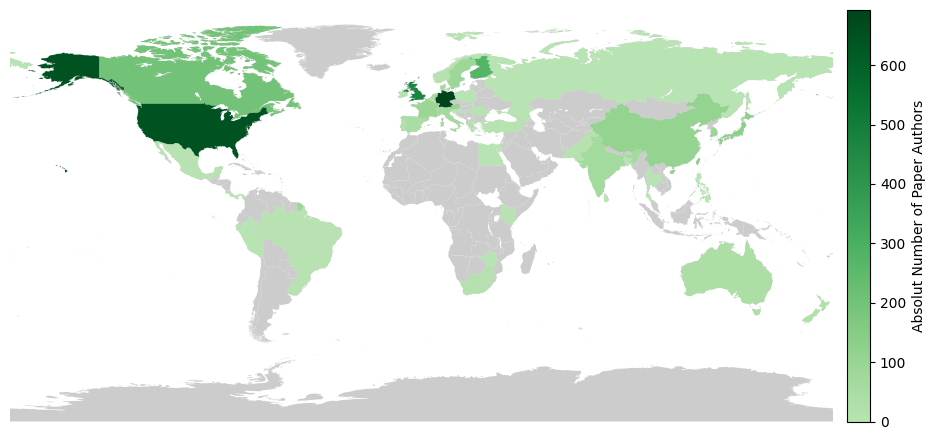

In [3]:
min_val, max_val = 0.3,1.0
n = 10
orig_cmap = plt.cm.Greens
colorsX = orig_cmap(np.linspace(min_val, max_val, n))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colorsX)


dfC = df.groupby("Alpha-3").count().Year.reset_index()
dfC = dfC.rename(columns={"Year":"Value"})
dfMap = pd.merge(gdf, dfC, on="Alpha-3", how="outer")


fig, axs = plt.subplots(1, 2,figsize=(10, 4.5), layout='tight', gridspec_kw={'width_ratios': [40, 1]})
ax = axs[0]
cax = axs[1]

ax2 = gdf.plot( color='#CCCCCC', ax=ax )

dfX = dfMap[~dfMap.Value.isna()]
dfX.plot( ax=ax, column='Value', legend=False, vmin=0, cmap=cmap)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=dfX.Value.max()))
cax.clear()
cbar = fig.colorbar(sm, ax=ax, cax=cax)
cbar.set_label('Absolut Number of Paper Authors')
cbar.ax.tick_params() 

ax.set_xlim(-180,180)
ax.set_ylim(-90,90)
ax.axis('off')

plt.savefig("./figures/paper_absoluteAuthorsPerCountry.png", bbox_inches='tight', pad_inches=0, dpi=300, transparent=False)
plt.show()

In [4]:
dfSingleCountryPapers = df.groupby("Doi")["Alpha-3"].apply(lambda x: x.nunique()).reset_index()
dfSingleCountryPapers = dfSingleCountryPapers.rename(columns={"Alpha-3":"CountryCount"})
paperCount = len(dfSingleCountryPapers)
dfSingleCountryPapers = dfSingleCountryPapers[dfSingleCountryPapers.CountryCount == 1]
print(f"All papers: {paperCount}, Single Country Papers: {len(dfSingleCountryPapers)}, {len(dfSingleCountryPapers)/paperCount*100:.2f}%")

All papers: 958, Single Country Papers: 680, 70.98%


In [5]:
dfSingleCountryPapersAuthorCountPerPaper = df[df.Doi.isin(dfSingleCountryPapers.Doi)].groupby(["Doi", "Alpha-3"]).count().Year.reset_index()
dfSingleCountryPapersAuthorCountPerPaper = dfSingleCountryPapersAuthorCountPerPaper.rename(columns={"Year":"AuthorCount"})
dfSingleCountryPapersAuthorCountPerPaper.groupby("Alpha-3").AuthorCount.describe().sort_values("mean", ascending=False).round(2)

,count,mean,std,min,25%,50%,75%,max
Alpha-3,,,,,,,,
TWN,14.0,5.21,1.72,3.0,4.00,5.5,6.75,8.0
IRL,1.0,5.00,NaN,5.0,5.00,5.0,5.00,5.0
CHN,13.0,4.38,1.33,3.0,4.00,4.0,5.00,8.0
NZL,4.0,4.25,0.96,3.0,3.75,4.5,5.00,5.0
IND,13.0,4.23,1.79,1.0,3.00,4.0,5.00,8.0
SGP,5.0,4.00,1.41,3.0,3.00,3.0,5.00,6.0
CAN,31.0,3.94,1.86,2.0,3.00,4.0,5.00,11.0
DEU,125.0,3.70,1.32,1.0,3.00,4.0,4.00,8.0
GBR,80.0,3.68,1.71,1.0,2.00,3.0,4.25,8.0


In [6]:
values = dfSingleCountryPapersAuthorCountPerPaper.groupby("Alpha-3").AuthorCount.apply(lambda x: list(x)).values
statistic, pvalue = scipy.stats.kruskal(*values)
print(f"H({len(values)}, n={len(dfSingleCountryPapers)}) = {statistic:.3f}, p={pvalue:.3f}")

H(32, n=680) = 51.236, p=0.013


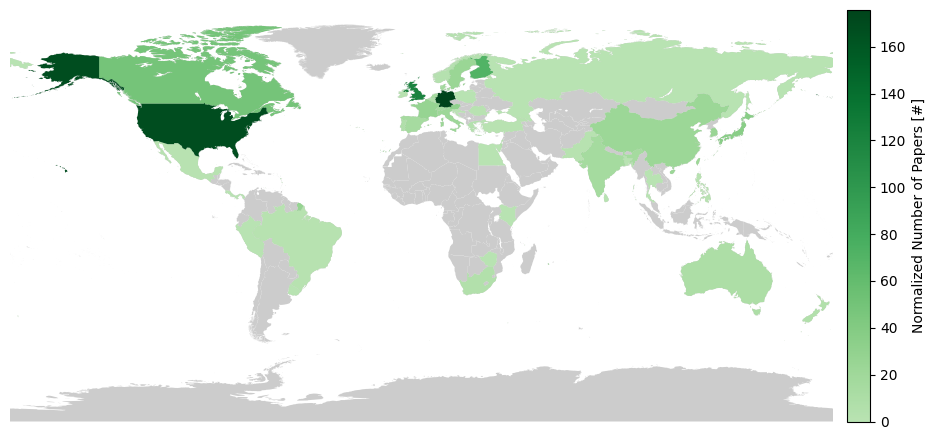

In [7]:
min_val, max_val = 0.3,1.0
n = 10
orig_cmap = plt.cm.Greens
colorsX = orig_cmap(np.linspace(min_val, max_val, n))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colorsX)


dfC = df.groupby("Alpha-3").AuthorContribution.sum().reset_index()
dfC = dfC.rename(columns={"AuthorContribution":"Value"})
dfMap = pd.merge(gdf, dfC, on="Alpha-3", how="outer")


fig, axs = plt.subplots(1, 2,figsize=(10, 4.5), layout='tight', gridspec_kw={'width_ratios': [40, 1]})
ax = axs[0]
cax = axs[1]

ax2 = gdf.plot( color='#CCCCCC', ax=ax )

dfX = dfMap[~dfMap.Value.isna()]
dfX.plot( ax=ax, column='Value', legend=False, vmin=0, cmap=cmap)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=dfX.Value.max()))
cax.clear()
cbar = fig.colorbar(sm, ax=ax, cax=cax)
cbar.set_label('Normalized Number of Papers [#]')
cbar.ax.tick_params() 

ax.set_xlim(-180,180)
ax.set_ylim(-90,90)
ax.axis('off')

plt.savefig("./figures/paper_AuthorContributionPerCountry.png", bbox_inches='tight', pad_inches=0, dpi=300, transparent=False)
plt.show()

In [8]:
lst = []
for alpah in df["Alpha-3"].unique():
    for year in df["Year"].unique():
        lst.append({"Alpha-3":alpah, "Year":year})

dfYearContribution  = pd.DataFrame(lst)

dfX = df.groupby(["Year", "Alpha-3"]).AuthorContribution.sum().reset_index()
dfYearContribution = pd.merge(dfYearContribution, dfX, on=["Year", "Alpha-3"], how="left")


dfX = df.groupby("Year").AuthorContribution.sum().reset_index()
dfX = dfX.rename(columns={"AuthorContribution":"TotalContribution"})

dfYearContribution = pd.merge(dfYearContribution, dfX, on="Year", how="left")

dfYearContribution.AuthorContribution = dfYearContribution.AuthorContribution.fillna(0)
dfYearContribution["AuthorContributionRatio"] = dfYearContribution.AuthorContribution/dfYearContribution.TotalContribution * 100
dfYearContribution["AuthorContributionRatio"] = dfYearContribution["AuthorContributionRatio"].fillna(0)

dfX = dfYearContribution.groupby("Alpha-3").AuthorContributionRatio.mean().reset_index()
dfX = dfX.rename(columns={"AuthorContributionRatio":"AuthorContributionRatioAverage"})

dfYearContribution = pd.merge(dfYearContribution, dfX, on="Alpha-3", how="left")

dfYearContribution.head()

,Alpha-3,Year,AuthorContribution,TotalContribution,AuthorContributionRatio,AuthorContributionRatioAverage
0,HKG,2005,0.666667,54.0,1.234568,0.648118
1,HKG,2006,0.000000,45.0,0.000000,0.648118
2,HKG,2007,0.000000,30.0,0.000000,0.648118
3,HKG,2008,0.000000,65.0,0.000000,0.648118
4,HKG,2009,0.000000,38.0,0.000000,0.648118


In [9]:
dfLocations = pd.read_csv("./data/locations.csv")
dfLocations = pd.merge(dfLocations, gdf, left_on="Alpha-3", right_on="Alpha-3", how="left")

# Only ACM DL Accaptance Rates
dfLocations = dfLocations[dfLocations.Year >= 2005]

In [10]:
for c in dfYearContribution.columns[2:]:
    if c in dfLocations.columns:
        dfLocations = dfLocations.drop(columns=[c]) 
dfLocations = pd.merge(dfLocations, dfYearContribution, on=["Year", "Alpha-3"], how="left")

dfLocations["LocalAuthoContributionRatioDiff"] = dfLocations.AuthorContributionRatio - dfLocations.AuthorContributionRatioAverage

In [11]:
statistic, pvalue = scipy.stats.wilcoxon(dfLocations.AuthorContributionRatio, dfLocations.AuthorContributionRatioAverage)
print(f"AuthoContribution: W={statistic}, p={pvalue:.3f}")

AuthoContribution: W=34.0, p=0.006


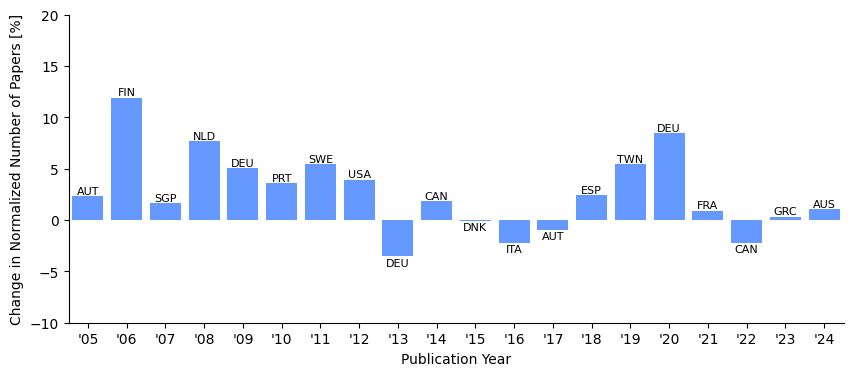

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.bar(dfLocations.Year, dfLocations.LocalAuthoContributionRatioDiff, color=colors[3])

ax.set_xticks(dfLocations.Year, dfLocations.Year.apply(lambda x: "'"+str(x)[2:]))
ax.set_xlim(dfLocations.Year.min()-.5, dfLocations.Year.max()+.5)
ax.set_ylim(np.floor(dfLocations.LocalAuthoContributionRatioDiff.min()/10)*10, np.ceil(dfLocations.LocalAuthoContributionRatioDiff.max()/10)*10)

for i, e in dfLocations.iterrows():
    if (e.LocalAuthoContributionRatioDiff > 0):
        y = e.LocalAuthoContributionRatioDiff
    else: 
        y = e.LocalAuthoContributionRatioDiff-1.1
    ax.text(e.Year, y, str(e["Alpha-3"]), ha='center', va='bottom', fontsize=8)



ax.set_xlabel("Publication Year")
ax.set_ylabel("Change in Normalized Number of Papers [%]")

ax.spines[['right', 'top']].set_visible(False)
# plt.legend(frameon=False, loc='upper left')
plt.savefig("./figures/paper_PaperContributionRate.png", bbox_inches='tight', pad_inches=0, dpi=300, transparent=False)
plt.show()

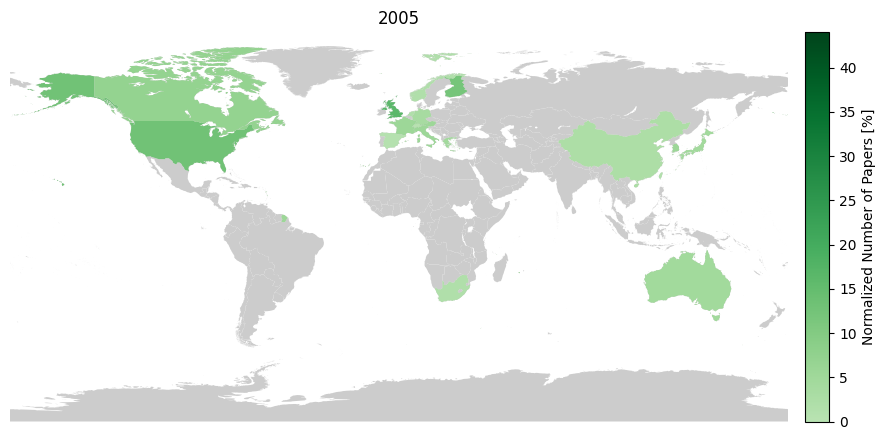

In [13]:
fig, axs = plt.subplots(1, 2,figsize=(10, 4.5), layout='tight', gridspec_kw={'width_ratios': [40, 1]})
ax = axs[0]
cax = axs[1]
ax2 = gdf.plot( color='#CCCCCC', ax=ax)

# Custom colormap without the very light colors in in the beginning
min_val, max_val = 0.3,1.0
n = 10
orig_cmap = plt.cm.Greens
colorsX = orig_cmap(np.linspace(min_val, max_val, n))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colorsX)

def animate(i):
    ax.clear()
    value = "Alpha-3"
    minYear = dfYearContribution.Year.min()
    dfC = dfYearContribution[(dfYearContribution.Year ==i+minYear) & (dfYearContribution.AuthorContributionRatio > 0)]

    dfMap = pd.merge(gdf, dfC, on="Alpha-3", how="right")

    ax2 = gdf.plot( color='#CCCCCC', ax=ax ) # will draw the world map.
    plot = dfMap.plot(ax=ax, column='AuthorContributionRatio', legend=False, vmin=0, vmax=dfYearContribution.AuthorContributionRatio.max(), cmap=cmap)

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=dfYearContribution.AuthorContributionRatio.max()))
    cax.clear()
    cbar = fig.colorbar(sm, ax=ax, cax=cax)
    cbar.set_label('Normalized Number of Papers [%]')
    cbar.ax.tick_params() 

    # crop the world
    ax.set_title(i+minYear)
    ax.set_xlim(-180,180)
    ax.set_ylim(-90,90)
    ax.axis('off')

    return plot,

ani = animation.FuncAnimation(fig, animate, repeat=True, frames=df.Year.max()-df.Year.min()+1, interval=1000)

writer = animation.PillowWriter(fps=1, metadata=dict(artist='Me'), bitrate=1800)
ani.save('./figures/paper_ContributionRatioPerCountryAndYear.gif', writer=writer, savefig_kwargs={"pad_inches" : 0})

Only showing the top 14 countries


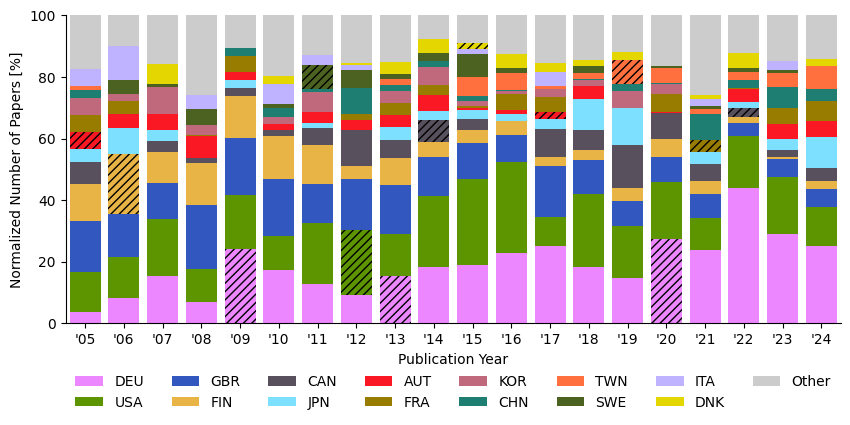

In [14]:
dfX = dfYearContribution.groupby("Alpha-3").mean().AuthorContributionRatio.reset_index()
dfX = dfX.sort_values("AuthorContributionRatio", ascending=False)

filterAlpha3 = dfX[dfX.AuthorContributionRatio >= 2]["Alpha-3"].values
print(f"Only showing the top {len(filterAlpha3)} countries")

color20 = ["#ec87ff","#5c9500","#3257bf","#e7b445","#58505c","#7ee0ff","#f91823","#977c00","#c0687c","#1d7e71","#ff703e","#4c6220","#bfb3ff","#e4d600","#872198","#c6ff16","#e82cd3","#38ff6d","#99273d","#92a3ab"]

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

for year in sorted(dfYearContribution.Year.unique()):
    y = 0
    for i, alpha3 in enumerate(filterAlpha3):

        dfX = dfYearContribution[(dfYearContribution.Year == year) & (dfYearContribution["Alpha-3"] == alpha3)]
        if (len(dfX) == 0):
            continue
        e = dfX.iloc[0]

        if len(dfLocations[(dfLocations.Year == year) & (dfLocations["Alpha-3"] == alpha3)]) > 0:
            ax.bar(year, e.AuthorContributionRatio, bottom=y, color=color20[i], hatch="////")
        else:
            ax.bar(year, e.AuthorContributionRatio, bottom=y, color=color20[i])
        y = y + e.AuthorContributionRatio

    if y != 100:
        ax.bar(year, 100-y, bottom=y, color="#CCCCCC")

ax.set_xticks(dfYearContribution.drop_duplicates("Year").sort_values("Year").Year.values, dfYearContribution.drop_duplicates("Year").sort_values("Year").Year.apply(lambda x: "'"+str(x)[2:]).values)
ax.set_xlim(dfYearContribution.Year.min()-0.5, dfYearContribution.Year.max()+0.5)
ax.set_ylim(0, 100)

lstPatches = []
lstNames = []
for i, alpha3 in enumerate(filterAlpha3):
    lstPatches.append(plt.Rectangle((0, 0), 1, 1, fc=color20[i]))
    lstNames.append(alpha3)
lstPatches.append(plt.Rectangle((0, 0), 1, 1, fc="#CCCCCC"))
lstNames.append("Other")

ax.legend(lstPatches, lstNames, loc='lower center', frameon=False, ncol=8, bbox_to_anchor=(0.5, -0.32))

ax.set_xlabel("Publication Year")
ax.set_ylabel("Normalized Number of Papers [%]")

ax.spines[['right', 'top']].set_visible(False)
plt.savefig("./figures/paper_ContributionPerCountry.png", bbox_inches='tight', pad_inches=0, dpi=300, transparent=False)
plt.show()


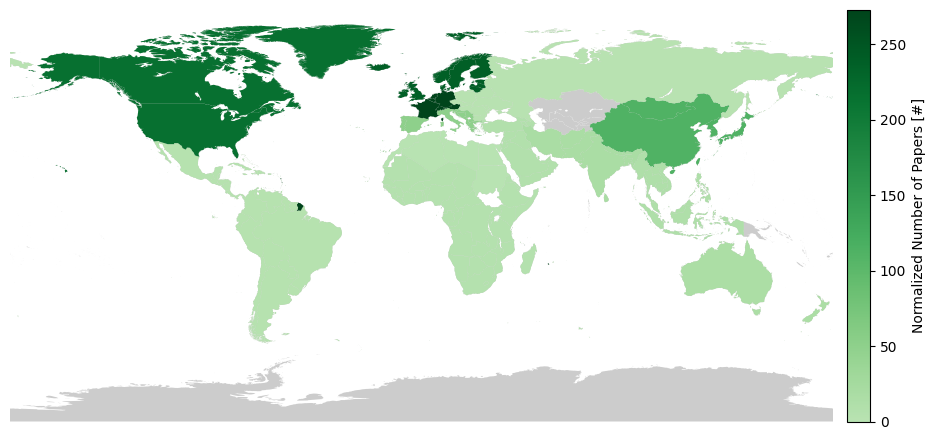

In [15]:
min_val, max_val = 0.3,1.0
n = 10
orig_cmap = plt.cm.Greens
colorsX = orig_cmap(np.linspace(min_val, max_val, n))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colorsX)


dfC = df.groupby("Alpha-3").AuthorContribution.sum().reset_index()
dfC = dfC.rename(columns={"AuthorContribution":"Value"})
dfMap = pd.merge(gdf, dfC, on="Alpha-3", how="outer")

dfContinent = dfMap.groupby("Sub-Region").Value.sum().reset_index()
del dfMap["Value"]
dfMap = pd.merge(dfMap, dfContinent[dfContinent.Value > 0], on="Sub-Region", how="inner")


fig, axs = plt.subplots(1, 2,figsize=(10, 4.5), layout='tight', gridspec_kw={'width_ratios': [40, 1]})
ax = axs[0]
cax = axs[1]

ax2 = gdf.plot( color='#CCCCCC', ax=ax )

dfX = dfMap[~dfMap.Value.isna()]
dfX.plot( ax=ax, column='Value', legend=False, vmin=0, cmap=cmap)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=dfX.Value.max()))
cax.clear()
cbar = fig.colorbar(sm, ax=ax, cax=cax)
cbar.set_label('Normalized Number of Papers [#]')
cbar.ax.tick_params() 

ax.set_xlim(-180,180)
ax.set_ylim(-90,90)
ax.axis('off')

plt.savefig("./figures/paper_AuthorContributionPerSubRegions.png", bbox_inches='tight', pad_inches=0, dpi=300, transparent=False)
plt.show()

In [16]:
dfContinent.sort_values("Value", ascending=False)

,Sub-Region,Value
16,Western Europe,272.634921
9,Northern Europe,239.173810
8,Northern America,216.444048
2,Eastern Asia,111.960317
13,Southern Europe,50.411905
12,Southern Asia,18.408333
0,Australia and New Zealand,16.000000
11,South-eastern Asia,11.775000
15,Western Asia,8.341667
14,Sub-Saharan Africa,6.128571
